In [1]:
import torch
import numpy as np
import pandas as pd

from NeuralProcessClasses_Proteins import *
from architecture_classes import *
from utils import *

In [2]:
msa = pd.read_csv('SH3_Full_Dataset_8_9_22.csv')
msa['Type'].unique()
naturals_msa = msa[msa['Type']=='Naturals']
seqs = np.asarray([list(seq) for seq in naturals_msa['Sequences']])
norm_re = np.asarray([re for re in naturals_msa['Norm_RE']])

default_aa_keys='-GALMFWKQESPVICYHRNDT'
def fasta_to_df(fasta_file, aa_keys = default_aa_keys):
    """
    creates one hot encoding of a fasta file using biopython's alignio.read process. 
    fasta_file : filepath leading to msa file in fasta format at hand
    """
    column_names = []
    column_names.extend(aa_keys)
    msa=AlignIO.read(fasta_file, "fasta")
    num_columns = len(msa[0].seq)
    column_names = column_names*num_columns
    column_names.append('sequence')
    column_names.append('id')
    init = np.zeros((len(msa), len(column_names)))
    df = pd.DataFrame(init, columns = column_names)
    df.sequence = df.sequence.astype(str)
    df.id=df.id.astype(str)
    
    for row_num, alignment in tqdm(enumerate(msa)):
        sequence = str(alignment.seq)
        for index, char in enumerate(sequence):
            place = aa_keys.find(char)
            df.iloc[row_num, index*len(aa_keys) + place] = 1
        
        df.iloc[row_num,-2]=str(alignment.seq)
        df.iloc[row_num,-1]=str(alignment.id)
    
    return df

In [3]:
def create_frequency_matrix(df, aa_keys = default_aa_keys):
    """takes one hot encoded msa and returns the frequency of each amino acid at each site
    df : pandas dataframe whose columns are the one hot encoding of an msa
    """
    num_columns=len(df['sequence'][0])
    
    frequency_matrix = np.zeros( (len(aa_keys) , num_columns) )
    print('calcing sum')
    freq=df.sum()
    print('sum calced')
    
    num_entries=len(df)
    len_aa_keys = len(aa_keys)
    
    for i in tqdm(range(len(aa_keys))):
        for j in range(num_columns):
            frequency_matrix[i, j] = freq[ i + len_aa_keys * j] / num_entries
    
    return frequency_matrix

In [4]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
vae_alignment = []
phenotypes = []

vae_data = msa[msa['Type']=='VAE'].reset_index()

for r in range(len(vae_data)):
    alignment = vae_data.loc[r]
    if len(alignment['Sequences'])==62:
        record = SeqRecord(seq = Seq(alignment['Sequences']), id = alignment['Header'])
    
    vae_alignment.append(record)
    phenotypes.append(alignment['Norm_RE'])

vae_alignment = AlignIO.MultipleSeqAlignment(vae_alignment)

AlignIO.write(vae_alignment, 'vae_alignment.fasta', 'fasta')

vae_df = fasta_to_df('vae_alignment.fasta')

freq_matrix = create_frequency_matrix(vae_df)

trim_positions = []

for i in range(freq_matrix.shape[1]):
    if 1 in freq_matrix[:,i]:
        trim_positions.append(i)

print(trim_positions)


vae_alignment_trimmed = []


for alignment in vae_alignment:
    new_seq = ''
    for i in range(62):
        if i not in trim_positions:
            new_seq+=alignment.seq[i]
    re_alignment = SeqRecord(seq=Seq(new_seq), id = alignment.id)
    vae_alignment_trimmed.append(re_alignment)

vae_alignment_trimmed = AlignIO.MultipleSeqAlignment(vae_alignment_trimmed)

AlignIO.write(vae_alignment_trimmed, 'vae_alignment_trimmed.fasta', 'fasta')

test_seqs = np.asarray([list(str(alignment.seq)) for alignment in vae_alignment_trimmed])

phenotypes = np.asarray(phenotypes)

11608it [01:01, 187.79it/s]


calcing sum
sum calced


100%|████████████████████████████████████████| 21/21 [00:00<00:00, 23252.48it/s]


[16, 17, 44]


In [5]:
class AddNorm(torch.nn.Module):
    def __init__(
        self,
        normalized_shape,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape)
    def forward(
        self,
        x,
        sub_layer_x
    ):
        add = x + sub_layer_x
        return self.layer_norm(add)

In [6]:
class AttentiveNeuralProcess_Deterministic(torch.nn.Module):
    def __init__(
        self,
        x_dim, 
        y_dim,
        projected_dim,
        d_hidden, 
        d_model,
        heads,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)
        self.activation = torch.nn.SELU()

        self.self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.dropout_1 = torch.nn.Dropout(0.1)

        self.self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.dropout_2 = torch.nn.Dropout(0.1)

        self.context_projection = torch.nn.Linear(x_dim, projected_dim)
        self.target_projection = torch.nn.Linear(x_dim, projected_dim)
        
        self.cross_mha = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)

        self.linear_2 = torch.nn.Linear(projected_dim + x_dim, projected_dim)
        self.linear_3 = torch.nn.Linear(projected_dim + x_dim, projected_dim)
        self.linear_4 = torch.nn.Linear(projected_dim + x_dim, projected_dim)
        self.linear_5 = torch.nn.Linear(projected_dim + x_dim, y_dim)

    def cross_entropy(self, x, y):
        return torch.sum(-y * torch.log(x + 1e-6) - (1.-y)*torch.log(1. - x + 1e-6))

    def forward(self, context_x, context_y, target_x, target_y = None):
        context = torch.concat([context_x, context_y], dim=-1)
        x_1 = self.activation(self.linear_1(context))

        x_2, _ = self.self_mha_1(x_1, x_1, x_1)
        x_2    = self.addnorm_1(x_2, x_1)
        x_2    = self.dropout_1(x_2)

        x_3, _ = self.self_mha_2(x_2, x_2, x_2)
        x_3    = self.addnorm_2(x_3, x_2)
        x_3    = self.dropout_2(x_2)

        projected_context = self.context_projection(context_x)
        projected_target  = self.target_projection(target_x)
        
        cross_attended,_ = self.cross_mha(projected_target, projected_context, x_3)
        
        yhat = torch.concat([cross_attended, x_target], dim=-1)
        yhat = self.activation(self.linear_2(yhat))
        
        yhat = torch.concat([yhat, x_target], dim=-1)
        yhat = self.activation(self.linear_3(yhat))
        
        yhat = torch.concat([yhat, x_target], dim=-1)
        yhat = self.activation(self.linear_4(yhat))

        yhat = torch.concat([yhat, x_target], dim=-1)
        yhat = self.linear_5(yhat)
        
        yhat = torch.nn.Softmax(dim=-1)(yhat)

        if target_y is not None:
            cross_entropy = self.cross_entropy(yhat, target_y)
            return yhat, cross_entropy
        else:
            return yhat, 0
                                     

        


In [7]:
ANP_det = AttentiveNeuralProcess_Deterministic(
    1, 21, 128, 128, 128, 8
)

In [8]:
ANP_det

AttentiveNeuralProcess_Deterministic(
  (linear_1): Linear(in_features=22, out_features=128, bias=True)
  (activation): SELU()
  (self_mha_1): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_1): AddNorm(
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (dropout_1): Dropout(p=0.1, inplace=False)
  (self_mha_2): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_2): AddNorm(
    (layer_norm): Laye

In [9]:
proteins = ProteinDataset(data=seqs)
min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]
loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)

for batch in loader:
    break
(((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)


In [10]:
ANP_det(x_context, y_context, x_target, y_target)

(tensor([[[3.5835e-04, 2.6647e-04, 7.5835e-03,  ..., 2.0244e-03,
           7.0126e-03, 2.3090e-02],
          [1.7431e-04, 1.2880e-04, 5.1384e-03,  ..., 1.1936e-03,
           4.8473e-03, 1.8830e-02],
          [1.3055e-04, 9.6441e-05, 4.3880e-03,  ..., 9.6454e-04,
           4.1777e-03, 1.7291e-02],
          ...,
          [1.1295e-04, 8.3479e-05, 4.0532e-03,  ..., 8.6688e-04,
           3.8779e-03, 1.6559e-02],
          [3.4965e-03, 2.7442e-03, 2.5257e-02,  ..., 1.0212e-02,
           2.0575e-02, 4.0891e-02],
          [1.6201e-02, 1.4010e-02, 5.0745e-02,  ..., 2.6948e-02,
           3.5486e-02, 5.1035e-02]],
 
         [[3.4747e-03, 2.7337e-03, 2.5280e-02,  ..., 1.0340e-02,
           2.0554e-02, 4.2116e-02],
          [7.9860e-03, 6.5923e-03, 3.7769e-02,  ..., 1.7812e-02,
           2.8404e-02, 4.8797e-02],
          [1.4951e-03, 1.1429e-03, 1.6387e-02,  ..., 5.7728e-03,
           1.4131e-02, 3.4720e-02],
          ...,
          [9.7647e-04, 7.3865e-04, 1.3092e-02,  ..., 4.264

In [11]:
def adjust_learning_rate(optimizer, step_num, warmup_step=4000):
    lr = 0.001 * warmup_step**0.5 * min(step_num * warmup_step**-1.5, step_num**-0.5)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

proteins = ProteinDataset(data=seqs)
syn_proteins = ProteinDataset(data=test_seqs)

EPOCHS=45
ANP_det.train()
optim = torch.optim.Adam(ANP_det.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    overall_loss = 0
    for i, batch in enumerate(loader):

        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = ANP_det(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    val_loader = torch.utils.data.DataLoader(syn_proteins, batch_size=32, shuffle=False)
    for batch in val_loader:
        
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        val_y_pred, val_loss = ANP_det(x_context, y_context, x_target, y_target)
        overall_loss += val_loss.item()

    print('validation loss at epoch {} is '.format(epoch) + str(overall_loss/(test_seqs.shape[0]*test_seqs.shape[1])))

validation loss at epoch 0 is 3.8505323911975067
validation loss at epoch 1 is 3.701777262273781
validation loss at epoch 2 is 3.680813300582992
validation loss at epoch 3 is 3.643248987698614
validation loss at epoch 4 is 3.6416000966695234
validation loss at epoch 5 is 3.5897274396312833
validation loss at epoch 6 is 3.562509667636799
validation loss at epoch 7 is 3.5311540430011465
validation loss at epoch 8 is 3.5015016741666236
validation loss at epoch 9 is 3.453404699134245
validation loss at epoch 10 is 3.49460342817709
validation loss at epoch 11 is 3.42166330228153
validation loss at epoch 12 is 3.4117346278814233
validation loss at epoch 13 is 3.372812533908024
validation loss at epoch 14 is 3.315049077772471
validation loss at epoch 15 is 3.281330435308532
validation loss at epoch 16 is 3.2751466547706634
validation loss at epoch 17 is 3.2154891567272332
validation loss at epoch 18 is 3.2729680870396676
validation loss at epoch 19 is 3.1846249895452634
validation loss at epo

In [38]:
x_target.shape

torch.Size([24, 59, 1])

In [13]:
val_y_pred[0][0]

tensor([2.6121e-02, 7.3778e-03, 7.5174e-03, 9.4540e-03, 2.5536e-02, 5.0070e-02,
        1.2349e-01, 4.0074e-03, 3.9315e-03, 4.0233e-02, 2.4191e-01, 2.1097e-02,
        9.9020e-03, 8.3307e-03, 7.9315e-04, 1.4710e-02, 1.1715e-02, 2.8449e-04,
        3.7828e-02, 2.9031e-01, 6.5380e-02], grad_fn=<SelectBackward0>)

In [28]:
AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
IDX_TO_AA = list(AMINO_ACIDS)
AA_TO_IDX = {aa: i for i, aa in enumerate(IDX_TO_AA)}

frequency_matrix = np.zeros((seqs.shape[1], len(AA_TO_IDX)))

for i in range(seqs.shape[0]):
    for j in range(seqs.shape[1]):
        frequency_matrix[j,AA_TO_IDX[seqs[i,j]]] += 1

In [29]:
frequency_matrix

array([[ 668.,  280.,  248., ...,   63.,  342.,  260.],
       [ 617.,  226.,  347., ...,  263.,  523.,  148.],
       [ 402.,  212.,  245., ...,  117.,  748.,  106.],
       ...,
       [ 586.,  319.,  239., ...,  329., 1128.,  295.],
       [ 394.,  255.,  299., ...,   56.,  310., 1194.],
       [ 465.,  380.,  233., ...,   76.,  371., 1591.]])

In [33]:
x_target[0,1]

tensor([27.])

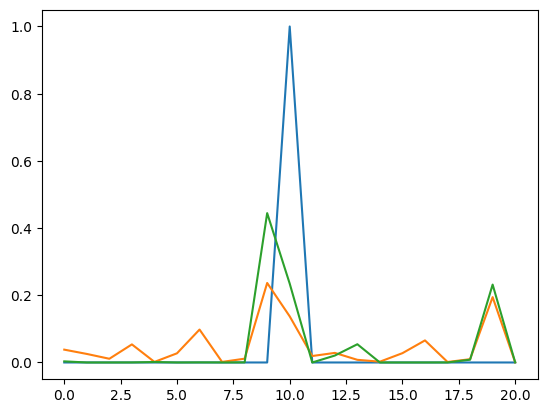

In [34]:
import matplotlib.pyplot as plt
plt.plot(y_target[0,1])
plt.plot(val_y_pred.detach().numpy()[0,1])
plt.plot(frequency_matrix[27]/7865)



In [93]:
x_target.shape

torch.Size([24, 59, 1])

In [39]:
class AttentiveNeuralProcess_Latent(torch.nn.Module):
    def __init__(
        self,
        x_dim, 
        y_dim,
        projected_dim,
        d_hidden, 
        d_model,
        heads,
        latent_dim,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)
        self.activation = torch.nn.SELU()

        self.deterministic_self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.dropout_1 = torch.nn.Dropout(0.1)

        self.deterministic_self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.dropout_2 = torch.nn.Dropout(0.1)

        self.latent_linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)

        self.latent_self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.latent_dropout_1 = torch.nn.Dropout(0.1)

        self.latent_self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.latent_dropout_2 = torch.nn.Dropout(0.1)

        self.latent_mu = torch.nn.Linear(projected_dim, latent_dim)
        self.latent_log_var = torch.nn.Linear(projected_dim, latent_dim)

    
        self.context_projection = torch.nn.Linear(x_dim, projected_dim)
        self.target_projection = torch.nn.Linear(x_dim, projected_dim)
        
        self.cross_mha = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)

        self.linear_2 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_3 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_4 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_5 = torch.nn.Linear(projected_dim + x_dim + latent_dim, y_dim)

    def cross_entropy(self, x, y):
        return torch.sum(-y * torch.log(x + 1e-6) - (1.-y)*torch.log(1. - x + 1e-6))

    def reparam(self, z_mu, z_log_var):
        return z_mu + torch.randn_like(z_log_var) * torch.exp(z_log_var/2.)

    def kl_loss_calc(
        self, z_mu_context, z_log_var_context,
              z_mu_target,  z_log_var_target
    ):
        q_context = torch.distributions.Normal(z_mu_context, torch.exp(z_log_var_context/2))
        q_target = torch.distributions.Normal(z_mu_target, torch.exp(z_log_var_target/2))
        
        kl = torch.distributions.kl.kl_divergence(q_context, q_target)
        return kl

    def forward(self, context_x, context_y, target_x, target_y = None):
        context = torch.concat([context_x, context_y], dim=-1)
        x_1 = self.activation(self.linear_1(context))

        x_2, _ = self.deterministic_self_mha_1(x_1, x_1, x_1)
        x_2    = self.addnorm_1(x_2, x_1)
        x_2    = self.dropout_1(x_2)

        x_3, _ = self.deterministic_self_mha_2(x_2, x_2, x_2)
        x_3    = self.addnorm_2(x_3, x_2)
        x_3    = self.dropout_2(x_2)

        projected_context = self.context_projection(context_x)
        projected_target  = self.target_projection(target_x)
        
        cross_attended,_ = self.cross_mha(projected_target, projected_context, x_3)

        z_1 = self.latent_linear_1(context)

        z_2, _ = self.latent_self_mha_1(z_1, z_1, z_1)
        z_2    = self.latent_addnorm_1(z_2, z_1)
        z_2    = self.latent_dropout_1(z_2)

        z_3, _ = self.latent_self_mha_2(z_2, z_2, z_2)
        z_3    = self.latent_addnorm_2(z_3, z_2)
        z_3    = self.latent_dropout_2(z_3)

        z_3 = torch.mean(z_3, dim=1)

        z_mu = self.latent_mu(z_3)
        z_log_var = self.latent_log_var(z_3)

        z = self.reparam(z_mu, z_log_var)

        z = z.unsqueeze(dim=1).tile([1, target_x.shape[1],1])

        yhat = torch.concat([cross_attended, target_x, z], dim=-1)
        yhat = self.activation(self.linear_2(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.activation(self.linear_3(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.activation(self.linear_4(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.linear_5(yhat)
        yhat = torch.nn.Softmax(dim=-1)(yhat)

        if target_y is not None:
            cross_entropy = self.cross_entropy(yhat, target_y)
            target = torch.concat([target_x, target_y], dim=-1)
            target_1 = self.activation(self.latent_linear_1(target))

            target_2, _ = self.latent_self_mha_1(target_1, target_1, target_1)
            target_2    = self.latent_addnorm_1(target_2, target_1)
            target_2    = self.latent_dropout_1(target_2)

            target_3, _ = self.latent_self_mha_2(target_2, target_2, target_2)
            target_3    = self.latent_addnorm_2(target_3, target_2)
            target_3    = self.latent_dropout_2(target_3)

            z_target    = torch.mean(target_3, dim=1)
            target_z_mu = self.latent_mu(z_target)
            target_z_log_var = self.latent_log_var(z_target)

            kl_loss = torch.sum(self.kl_loss_calc(z_mu, z_log_var, target_z_mu, target_z_log_var))
            
            return yhat, cross_entropy + kl_loss
        else:
            return yhat, 0
                                     



In [40]:
ANP_lat = AttentiveNeuralProcess_Latent(
    1, 21, 128, 128, 128, 8, 4
)

In [43]:
ANP_lat

AttentiveNeuralProcess_Latent(
  (linear_1): Linear(in_features=22, out_features=128, bias=True)
  (activation): SELU()
  (deterministic_self_mha_1): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_1): AddNorm(
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (dropout_1): Dropout(p=0.1, inplace=False)
  (deterministic_self_mha_2): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_2): AddNorm(
 

In [63]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

proteins = ProteinDataset(data=seqs)
syn_proteins = ProteinDataset(data=test_seqs)

EPOCHS=45
ANP_lat.train()
optim = torch.optim.Adam(ANP_lat.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    overall_loss = 0
    for i, batch in tqdm(enumerate(loader)):
        ANP_lat.train()
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = ANP_lat(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    val_loader = torch.utils.data.DataLoader(syn_proteins, batch_size=32, shuffle=False)
    for batch in val_loader:
        ANP_lat.eval()
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        val_y_pred, val_loss = ANP_lat(x_context, y_context, x_target, y_target)
        overall_loss += val_loss.item()

    print('validation loss at epoch {} is '.format(epoch) + str(overall_loss/(test_seqs.shape[0]*test_seqs.shape[1])))

246it [00:39,  6.26it/s]


validation loss at epoch 0 is 2.403362443718954


246it [00:40,  6.11it/s]


validation loss at epoch 1 is 2.409736651748429


246it [00:39,  6.19it/s]


validation loss at epoch 2 is 2.4119442259545854


246it [00:38,  6.31it/s]


validation loss at epoch 3 is 2.4361303553802753


246it [00:38,  6.35it/s]


validation loss at epoch 4 is 2.411276108123352


246it [00:40,  6.06it/s]


validation loss at epoch 5 is 2.423185245689614


246it [1:01:15, 14.94s/it] 


validation loss at epoch 6 is 2.4216027041652035


246it [1:51:35, 27.22s/it] 


validation loss at epoch 7 is 2.4225256351648783


246it [2:15:30, 33.05s/it] 


validation loss at epoch 8 is 2.4434893391233143


246it [2:05:13, 30.54s/it] 


validation loss at epoch 9 is 2.445725719108484


246it [1:31:25, 22.30s/it] 


validation loss at epoch 10 is 2.4557446294195757


246it [19:02,  4.64s/it] 


validation loss at epoch 11 is 2.4766348942730128


246it [09:28,  2.31s/it]


validation loss at epoch 12 is 2.446455692704371


246it [02:06,  1.95it/s]


validation loss at epoch 13 is 2.4757698304248597


246it [48:38, 11.86s/it]


validation loss at epoch 14 is 2.4633530449650856


246it [09:09,  2.24s/it]


validation loss at epoch 15 is 2.507366348543049


246it [01:17,  3.17it/s]


validation loss at epoch 16 is 2.4650462470656014


246it [14:31,  3.54s/it] 


validation loss at epoch 17 is 2.5176171117416604


246it [06:28,  1.58s/it]


validation loss at epoch 18 is 2.4648900398712734


246it [22:27,  5.48s/it] 


validation loss at epoch 19 is 2.473365470259634


246it [1:13:26, 17.91s/it] 


validation loss at epoch 20 is 2.519618623049955


246it [00:38,  6.47it/s]


validation loss at epoch 21 is 2.4492191784844923


246it [00:39,  6.30it/s]


validation loss at epoch 22 is 2.440538819862279


246it [2:12:55, 32.42s/it] 


validation loss at epoch 23 is 2.4645877444183912


246it [12:32,  3.06s/it] 


validation loss at epoch 24 is 2.444397916605448


246it [02:09,  1.89it/s]


validation loss at epoch 25 is 2.4075117146519487


246it [1:51:07, 27.10s/it] 


validation loss at epoch 26 is 2.435329382046595


246it [35:28,  8.65s/it]


validation loss at epoch 27 is 2.448503319923513


246it [34:46,  8.48s/it] 


validation loss at epoch 28 is 2.4091270901373725


246it [10:32,  2.57s/it] 


validation loss at epoch 29 is 2.429644330365633


246it [00:39,  6.30it/s]


validation loss at epoch 30 is 2.433192218679412


246it [00:38,  6.44it/s]


validation loss at epoch 31 is 2.4296452696806394


246it [00:37,  6.51it/s]


validation loss at epoch 32 is 2.44679576394898


246it [23:00,  5.61s/it] 


validation loss at epoch 33 is 2.4034149352081258


246it [00:37,  6.64it/s]


validation loss at epoch 34 is 2.4034731474286892


246it [00:37,  6.49it/s]


validation loss at epoch 35 is 2.4172721276122124


246it [00:38,  6.40it/s]


validation loss at epoch 36 is 2.4027516205383312


246it [00:37,  6.53it/s]


validation loss at epoch 37 is 2.3905020663019423


246it [00:38,  6.45it/s]


validation loss at epoch 38 is 2.418035717634554


246it [01:39,  2.48it/s]


validation loss at epoch 39 is 2.434272255906601


246it [00:37,  6.60it/s]


validation loss at epoch 40 is 2.4376007886783952


246it [00:36,  6.65it/s]


validation loss at epoch 41 is 2.402119618388774


246it [07:10,  1.75s/it] 


validation loss at epoch 42 is 2.4030372692617425


246it [00:37,  6.54it/s]


validation loss at epoch 43 is 2.4337051716529694


246it [00:37,  6.48it/s]


validation loss at epoch 44 is 2.3831325943137003


In [53]:
x_target[0]

tensor([[21.],
        [46.],
        [11.],
        [39.],
        [30.],
        [ 7.],
        [42.],
        [10.],
        [51.],
        [22.],
        [36.],
        [55.],
        [13.],
        [24.],
        [ 6.],
        [17.],
        [ 4.],
        [25.],
        [ 0.],
        [41.],
        [57.],
        [29.],
        [49.],
        [44.],
        [38.],
        [43.],
        [33.],
        [52.],
        [31.],
        [37.],
        [56.],
        [ 9.],
        [18.],
        [26.],
        [12.],
        [ 5.],
        [50.],
        [16.],
        [28.],
        [54.],
        [15.],
        [27.],
        [ 2.],
        [23.],
        [48.],
        [35.],
        [58.],
        [19.],
        [14.],
        [47.],
        [20.],
        [ 1.],
        [ 8.],
        [45.],
        [ 3.],
        [40.],
        [34.],
        [53.],
        [32.]])

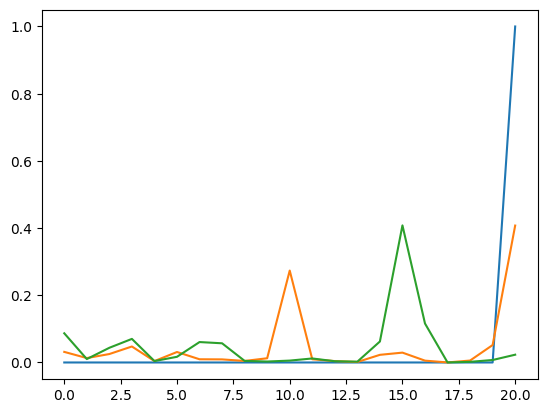

In [62]:
import matplotlib.pyplot as plt
plt.plot(y_target[0,20])
plt.plot(val_y_pred.detach().numpy()[0,20])
plt.plot(frequency_matrix[20]/7865)

In [89]:
other_test = torch.randn((10,5,3))

In [90]:
other_test

tensor([[[ 5.7885e-01,  1.8503e+00,  4.2787e-01],
         [ 1.0071e+00,  1.4661e+00, -1.0260e-01],
         [-1.3728e+00,  1.9242e+00, -6.2077e-01],
         [-6.5727e-01, -7.5758e-01,  5.4797e-01],
         [-1.0862e+00,  1.4214e+00, -1.4982e-01]],

        [[-7.6549e-01,  1.5078e-01,  2.9107e-04],
         [-2.7137e-01, -1.8251e+00,  1.6859e+00],
         [-2.1129e+00,  2.3690e+00,  8.0102e-01],
         [ 2.6335e-02,  1.9552e-01, -4.6229e-01],
         [-2.7230e+00, -1.3442e+00, -8.8763e-01]],

        [[ 5.1638e-01,  7.2710e-01, -1.8898e+00],
         [-3.2572e-01,  1.0587e+00, -9.0792e-01],
         [-1.1495e+00,  4.6414e-01, -4.8468e-01],
         [ 1.0646e+00,  4.4712e-01, -6.7189e-01],
         [-9.7373e-01, -3.1889e-01, -1.9782e+00]],

        [[ 1.4106e+00,  8.3720e-01,  2.1635e-01],
         [-1.3530e+00,  2.7244e-01,  8.5228e-01],
         [-2.9217e+00,  4.1772e-03,  9.2262e-01],
         [ 1.2403e+00,  5.4462e-01, -1.6630e-01],
         [-5.1164e-01,  1.2458e+00,  9.4213e

In [91]:
torch.concat([test, other_test], dim=-1)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 5 for tensor number 1 in the list.

In [64]:
class AttentiveNeuralProcess_Latent_3_layer(torch.nn.Module):
    def __init__(
        self,
        x_dim, 
        y_dim,
        projected_dim,
        d_hidden, 
        d_model,
        heads,
        latent_dim,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)
        self.activation = torch.nn.SELU()

        self.deterministic_self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.dropout_1 = torch.nn.Dropout(0.1)

        self.deterministic_self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.dropout_2 = torch.nn.Dropout(0.1)

        self.deterministic_self_mha_3 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_3 = AddNorm(normalized_shape=projected_dim)
        self.dropout_3 = torch.nn.Dropout(0.1)

        
        self.latent_linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)

        self.latent_self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.latent_dropout_1 = torch.nn.Dropout(0.1)

        self.latent_self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.latent_dropout_2 = torch.nn.Dropout(0.1)

        self.latent_self_mha_3 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_3 = AddNorm(normalized_shape=projected_dim)
        self.latent_dropout_3 = torch.nn.Dropout(0.1)
        
        self.latent_mu = torch.nn.Linear(projected_dim, latent_dim)
        self.latent_log_var = torch.nn.Linear(projected_dim, latent_dim)

    
        self.context_projection = torch.nn.Linear(x_dim, projected_dim)
        self.target_projection = torch.nn.Linear(x_dim, projected_dim)
        
        self.cross_mha = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)

        self.linear_2 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_3 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_4 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_5 = torch.nn.Linear(projected_dim + x_dim + latent_dim, y_dim)

    def cross_entropy(self, x, y):
        return torch.sum(-y * torch.log(x + 1e-6) - (1.-y)*torch.log(1. - x + 1e-6))

    def reparam(self, z_mu, z_log_var):
        return z_mu + torch.randn_like(z_log_var) * torch.exp(z_log_var/2.)

    def kl_loss_calc(
        self, z_mu_context, z_log_var_context,
              z_mu_target,  z_log_var_target
    ):
        q_context = torch.distributions.Normal(z_mu_context, torch.exp(z_log_var_context/2))
        q_target = torch.distributions.Normal(z_mu_target, torch.exp(z_log_var_target/2))
        
        kl = torch.distributions.kl.kl_divergence(q_context, q_target)
        return kl

    def forward(self, context_x, context_y, target_x, target_y = None):
        context = torch.concat([context_x, context_y], dim=-1)
        x_1 = self.activation(self.linear_1(context))

        x_2, _ = self.deterministic_self_mha_1(x_1, x_1, x_1)
        x_2    = self.addnorm_1(x_2, x_1)
        x_2    = self.dropout_1(x_2)

        x_3, _ = self.deterministic_self_mha_2(x_2, x_2, x_2)
        x_3    = self.addnorm_2(x_3, x_2)
        x_3    = self.dropout_2(x_2)

        x_4, _ = self.deterministic_self_mha_2(x_3, x_3, x_3)
        x_4    = self.addnorm_2(x_4, x_3)
        x_4    = self.dropout_2(x_4)


        projected_context = self.context_projection(context_x)
        projected_target  = self.target_projection(target_x)
        
        cross_attended,_ = self.cross_mha(projected_target, projected_context, x_3)

        z_1 = self.latent_linear_1(context)

        z_2, _ = self.latent_self_mha_1(z_1, z_1, z_1)
        z_2    = self.latent_addnorm_1(z_2, z_1)
        z_2    = self.latent_dropout_1(z_2)

        z_3, _ = self.latent_self_mha_2(z_2, z_2, z_2)
        z_3    = self.latent_addnorm_2(z_3, z_2)
        z_3    = self.latent_dropout_2(z_3)

        z_4, _ = self.latent_self_mha_2(z_2, z_2, z_2)
        z_4    = self.latent_addnorm_2(z_3, z_2)
        z_4    = self.latent_dropout_2(z_3)

        z_4 = torch.mean(z_4, dim=1)

        z_mu = self.latent_mu(z_4)
        z_log_var = self.latent_log_var(z_4)

        z = self.reparam(z_mu, z_log_var)

        z = z.unsqueeze(dim=1).tile([1, target_x.shape[1],1])

        yhat = torch.concat([cross_attended, target_x, z], dim=-1)
        yhat = self.activation(self.linear_2(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.activation(self.linear_3(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.activation(self.linear_4(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.linear_5(yhat)
        yhat = torch.nn.Softmax(dim=-1)(yhat)

        if target_y is not None:
            cross_entropy = self.cross_entropy(yhat, target_y)
            target = torch.concat([target_x, target_y], dim=-1)
            target_1 = self.activation(self.latent_linear_1(target))

            target_2, _ = self.latent_self_mha_1(target_1, target_1, target_1)
            target_2    = self.latent_addnorm_1(target_2, target_1)
            target_2    = self.latent_dropout_1(target_2)

            target_3, _ = self.latent_self_mha_2(target_2, target_2, target_2)
            target_3    = self.latent_addnorm_2(target_3, target_2)
            target_3    = self.latent_dropout_2(target_3)

            z_target    = torch.mean(target_3, dim=1)
            target_z_mu = self.latent_mu(z_target)
            target_z_log_var = self.latent_log_var(z_target)

            kl_loss = torch.sum(self.kl_loss_calc(z_mu, z_log_var, target_z_mu, target_z_log_var))
            
            return yhat, cross_entropy + kl_loss
        else:
            return yhat, 0
                                     



In [65]:
ANP_lat = AttentiveNeuralProcess_Latent_3_layer(
    1, 21, 128, 128, 128, 8, 4
)

In [68]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

proteins = ProteinDataset(data=seqs)
syn_proteins = ProteinDataset(data=test_seqs)

EPOCHS=45
ANP_lat.train()
optim = torch.optim.Adam(ANP_lat.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    overall_loss = 0
    for i, batch in tqdm(enumerate(loader)):
        ANP_lat.train()
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = ANP_lat(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    val_loader = torch.utils.data.DataLoader(syn_proteins, batch_size=32, shuffle=False)
    for batch in val_loader:
        ANP_lat.eval()
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        val_y_pred, val_loss = ANP_lat(x_context, y_context, x_target, y_target)
        overall_loss += val_loss.item()

    print('validation loss at epoch {} is '.format(epoch) + str(overall_loss/(test_seqs.shape[0]*test_seqs.shape[1])))

246it [00:41,  5.92it/s]


validation loss at epoch 0 is 2.5417433203559616


246it [00:41,  5.94it/s]


validation loss at epoch 1 is 2.529294812784702


246it [00:40,  6.06it/s]


validation loss at epoch 2 is 2.5290895630092423


246it [00:41,  5.96it/s]


validation loss at epoch 3 is 2.5326671818015125


246it [00:39,  6.26it/s]


validation loss at epoch 4 is 2.52709189451528


246it [00:43,  5.62it/s]


validation loss at epoch 5 is 2.5726727177070816


246it [00:41,  5.93it/s]


validation loss at epoch 6 is 2.5487801254684728


246it [00:41,  6.00it/s]


validation loss at epoch 7 is 2.5761113214432085


246it [04:43,  1.15s/it]


validation loss at epoch 8 is 2.558925616229999


246it [00:40,  6.12it/s]


validation loss at epoch 9 is 2.5438021395044896


246it [00:40,  6.02it/s]


validation loss at epoch 10 is 2.584477222354711


246it [00:39,  6.27it/s]


validation loss at epoch 11 is 2.6337592842536863


246it [00:41,  5.90it/s]


validation loss at epoch 12 is 2.5490519133245657


246it [00:41,  5.95it/s]


validation loss at epoch 13 is 2.5618211910885584


246it [00:46,  5.32it/s]


validation loss at epoch 14 is 2.5997600225902158


246it [00:43,  5.63it/s]


validation loss at epoch 15 is 2.5654792170277347


246it [00:44,  5.50it/s]


validation loss at epoch 16 is 2.5506054843779205


246it [00:41,  5.99it/s]


validation loss at epoch 17 is 2.549829810522532


246it [00:45,  5.47it/s]


validation loss at epoch 18 is 2.609569966860596


246it [00:46,  5.24it/s]


validation loss at epoch 19 is 2.534517259132911


246it [00:44,  5.48it/s]


validation loss at epoch 20 is 2.535516987244172


246it [00:43,  5.65it/s]


validation loss at epoch 21 is 2.5466085190063343


246it [00:39,  6.30it/s]


validation loss at epoch 22 is 2.5013243724882397


246it [00:44,  5.58it/s]


validation loss at epoch 23 is 2.530390731386782


246it [00:49,  5.01it/s]


validation loss at epoch 24 is 2.510833609407579


246it [00:42,  5.85it/s]


validation loss at epoch 25 is 2.5014536742786198


246it [00:45,  5.47it/s]


validation loss at epoch 26 is 2.495993199804238


246it [00:44,  5.49it/s]


validation loss at epoch 27 is 2.4816210838257002


246it [00:41,  5.99it/s]


validation loss at epoch 28 is 2.5225114676566616


246it [00:40,  6.02it/s]


validation loss at epoch 29 is 2.5366969736481098


246it [00:42,  5.84it/s]


validation loss at epoch 30 is 2.4755623901026396


246it [00:40,  6.01it/s]


validation loss at epoch 31 is 2.4876572514559516


246it [00:54,  4.52it/s]


validation loss at epoch 32 is 2.467463891675995


246it [00:46,  5.33it/s]


validation loss at epoch 33 is 2.463038907370077


246it [00:52,  4.72it/s]


validation loss at epoch 34 is 2.481537901154454


246it [00:44,  5.49it/s]


validation loss at epoch 35 is 2.4543405819867163


246it [00:40,  6.01it/s]


validation loss at epoch 36 is 2.4717702542209756


246it [00:41,  5.87it/s]


validation loss at epoch 37 is 2.4543051988638025


246it [00:42,  5.86it/s]


validation loss at epoch 38 is 2.4408140020855402


246it [00:40,  6.08it/s]


validation loss at epoch 39 is 2.4516071396712635


246it [00:40,  6.11it/s]


validation loss at epoch 40 is 2.436850502707417


246it [00:43,  5.72it/s]


validation loss at epoch 41 is 2.4443240864459663


246it [00:40,  6.07it/s]


validation loss at epoch 42 is 2.44336383665716


246it [00:41,  5.91it/s]


validation loss at epoch 43 is 2.435263299899128


246it [00:41,  5.97it/s]


validation loss at epoch 44 is 2.4438319784230664


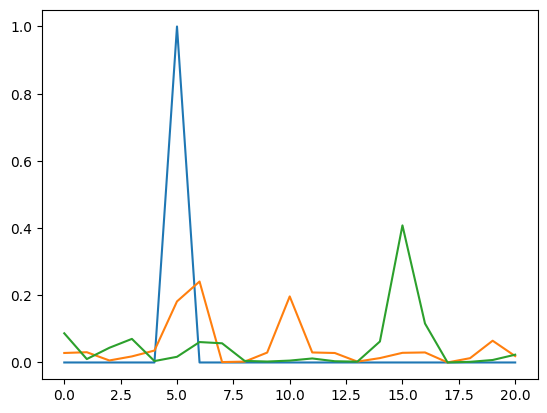

In [69]:
import matplotlib.pyplot as plt
plt.plot(y_target[0,20])
plt.plot(val_y_pred.detach().numpy()[0,20])
plt.plot(frequency_matrix[20]/7865)

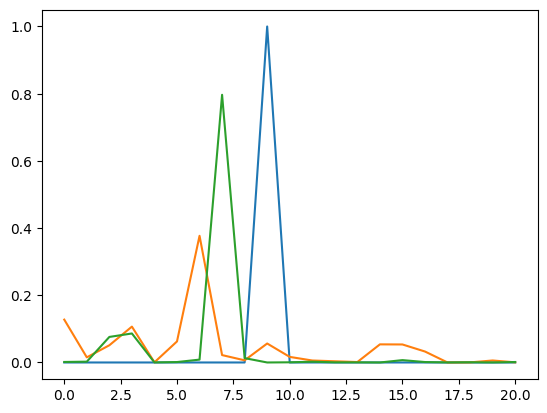

In [86]:
import matplotlib.pyplot as plt
plt.plot(y_target[0,24])
plt.plot(val_y_pred.detach().numpy()[0,24])
plt.plot(frequency_matrix[24]/7865)

In [83]:
x_target[0]

tensor([[11.],
        [22.],
        [ 8.],
        [46.],
        [19.],
        [16.],
        [40.],
        [ 9.],
        [57.],
        [17.],
        [36.],
        [47.],
        [18.],
        [26.],
        [21.],
        [ 2.],
        [ 6.],
        [55.],
        [38.],
        [51.],
        [54.],
        [29.],
        [14.],
        [25.],
        [15.],
        [43.],
        [31.],
        [49.],
        [32.],
        [12.],
        [ 7.],
        [42.],
        [41.],
        [28.],
        [30.],
        [27.],
        [20.],
        [13.],
        [50.],
        [45.],
        [44.],
        [39.],
        [53.],
        [34.],
        [ 4.],
        [37.],
        [52.],
        [ 5.],
        [58.],
        [ 1.],
        [23.],
        [ 3.],
        [48.],
        [24.],
        [56.],
        [33.],
        [35.],
        [ 0.],
        [10.]])

In [80]:
x_target[0]

tensor([[11.],
        [22.],
        [ 8.],
        [46.],
        [19.],
        [16.],
        [40.],
        [ 9.],
        [57.],
        [17.],
        [36.],
        [47.],
        [18.],
        [26.],
        [21.],
        [ 2.],
        [ 6.],
        [55.],
        [38.],
        [51.],
        [54.],
        [29.],
        [14.],
        [25.],
        [15.],
        [43.],
        [31.],
        [49.],
        [32.],
        [12.],
        [ 7.],
        [42.],
        [41.],
        [28.],
        [30.],
        [27.],
        [20.],
        [13.],
        [50.],
        [45.],
        [44.],
        [39.],
        [53.],
        [34.],
        [ 4.],
        [37.],
        [52.],
        [ 5.],
        [58.],
        [ 1.],
        [23.],
        [ 3.],
        [48.],
        [24.],
        [56.],
        [33.],
        [35.],
        [ 0.],
        [10.]])